# MIGROS Location intelligence analysis
For more explanations see the following post: https://matteo-jriva.medium.com/location-intelligence-the-branch-network-optimization-problem-4aa4740088d8
Fro an interactrive map of results, see the following link: https://www.google.com/maps/d/u/0/edit?mid=1_uX0U2V-byD1GLv0KRuWC2Gxv2wRuNT7&usp=sharing

*Location intelligence  is the process of deriving meaningful insight from geospatial data relationships to solve a particular business problem.*

This projects addresses a particular problem for retail stores, called _"Branch Network optimisation"_. In this type of analysis, geospatial data are used to determine optimal location for retail branches stores in order to improve spatial coverage and fill gaps in the branch network. 

Here we will try to identify geospatial features that explain Migros Supermarket locations within the canton of Zurich, and feed this information to a machine learning model in order to identify promising locations for addtional branches


In [119]:
# Imports
import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import numpy as np

%matplotlib inline
import gdal
%config Completer.use_jedi = False
from scipy import stats
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Import data

All data unless otherwise specified was downloaded from OSM using QGIS.
The first step is to get list of existing Migros (our target).

The following additional data was used to define spatial relationships (our predictors):
Main urban and suburban roads 
1. Location of bus stops 
1. Location of train stations 
1. Population density per municipality (source: Federal Statistical Office)
1. Location of other supermarkets 

In [175]:
# origin folder
fold_path = "../input_data/input_geo_data_rasterFormat"
assert os.path.exists(fold_path), "input folder does not exist. Please download the data from https://www.dropbox.com/s/ifvp73nkzupzycg and change the name of the folder accordingly"

# import ref_grid
ref_name = "ref_100m.tif"
file = gdal.Open(os.path.join(fold_path, ref_name))
ref_array = file.GetRasterBand(1).ReadAsArray()

# import all predictors
predictors={}

for file_name in os.listdir(fold_path):
    if file_name.endswith(".tif"):
        file_n = file_name.split('.')[0]
        file = gdal.Open(os.path.join(fold_path, file_name))
        array = file.GetRasterBand(1).ReadAsArray()
        
             
        # mask out of zurich
        array = np.ma.masked_where(ref_array != 1, array)
        
        # normalise
        min_val = np.ma.min(array[array>-9999])
        array = 100*( array  - min_val ) /( np.ma.max(array) - min_val )
   
        
        
        predictors[file_n] = array
        print(f"\n\nimported file {file_n},\n shape : {array.shape},\n max : {np.ma.max(array)}, \n min : {min_val} ")
        plt.pause(0.6)



imported file night_image_2,
 shape : (618, 472),
 max : 100.0, 
 min : 150.0 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/numpy/ma/core.py:1021: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)




imported file bus,
 shape : (618, 472),
 max : 100.0, 
 min : 9.635871833779674e-08 


imported file sups_aldi,
 shape : (618, 472),
 max : 100.0, 
 min : 1.769067438295889e-23 


imported file night_image,
 shape : (618, 472),
 max : 100.0, 
 min : 0.15000000596046448 


imported file trains,
 shape : (618, 472),
 max : 100.0, 
 min : 1.0249701531961364e-08 


imported file pop_municipalities,
 shape : (618, 472),
 max : 100.0, 
 min : 362.0 


imported file sups_coop,
 shape : (618, 472),
 max : 100.0, 
 min : 3.169149154665889e-26 


imported file target,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


imported file ref_100m,
 shape : (618, 472),
 max : --, 
 min : 1.0 


imported file streets,
 shape : (618, 472),
 max : 100.0, 
 min : 7.627654667885508e-07 


imported file sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 4.169816821644959e-20 


In [121]:
# 3d display
def make_3d_map(array, title=None, mask=None, pos=111, cmap=None):
    array[ mask==0 ] = np.NaN
    ny, nx = array.shape

    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)

    xv, yv = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(pos, projection='3d')
    ax.plot_surface(xv,yv,array)
    # fig.suptitle(title)
    ax.axis(False)
    ax.grid(False)

## Explore raw data



 Predictors: night_image_2,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


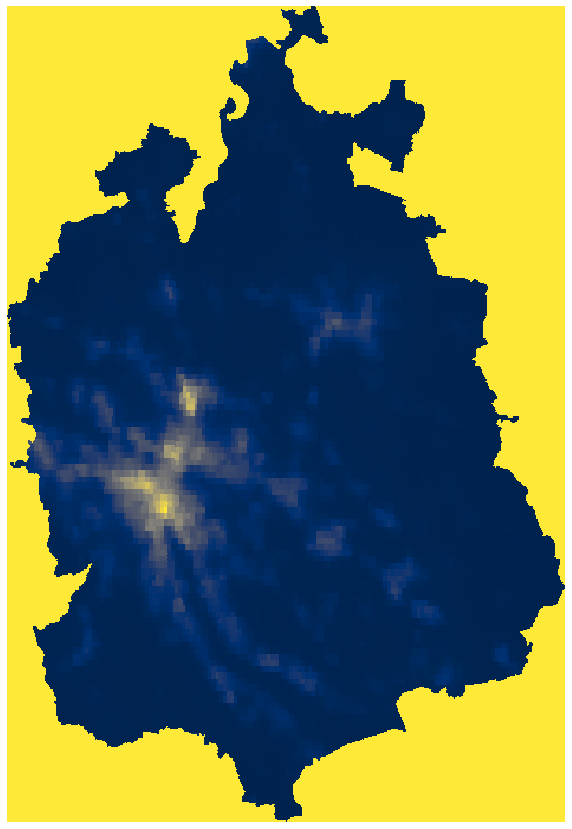

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


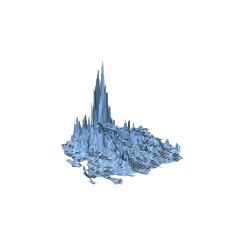

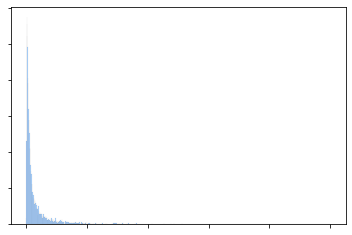



 Predictors: bus,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


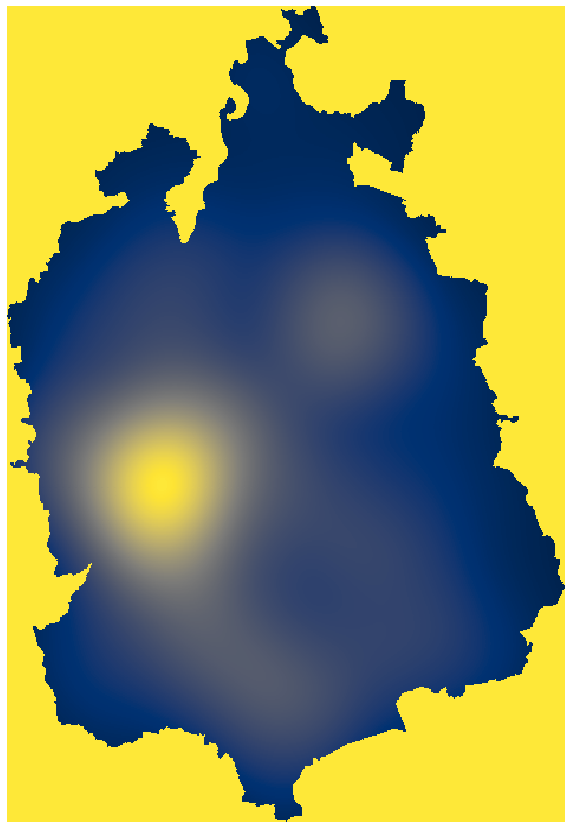

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


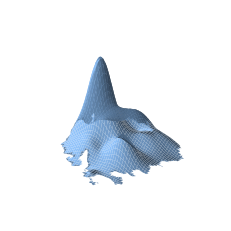

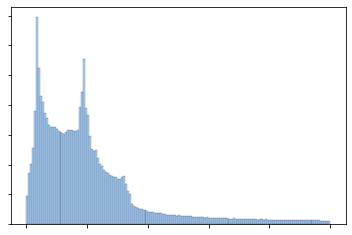



 Predictors: sups_aldi,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


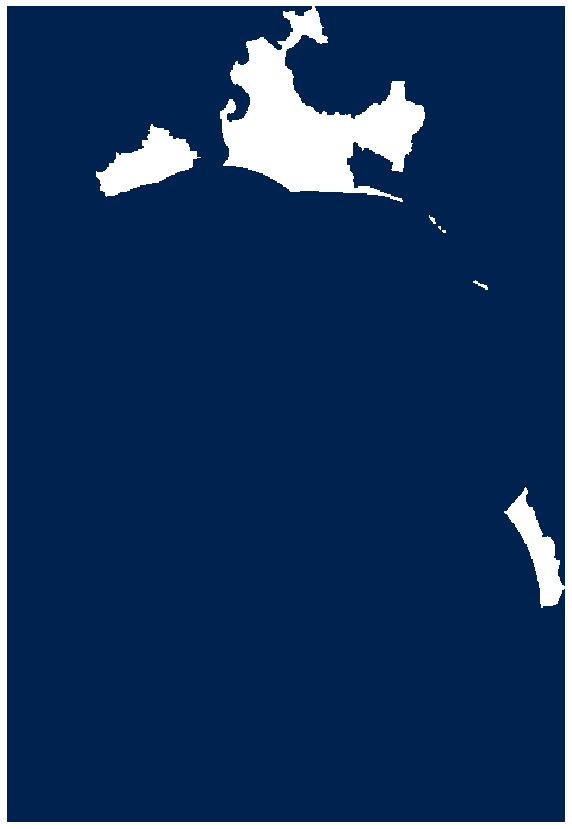

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1713: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1712: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/numpy/core/numeric.py:1632: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


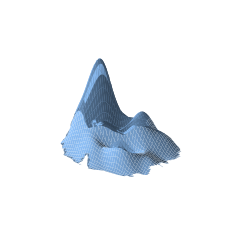

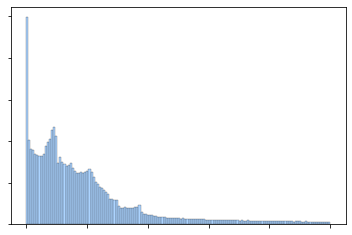



 Predictors: night_image,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


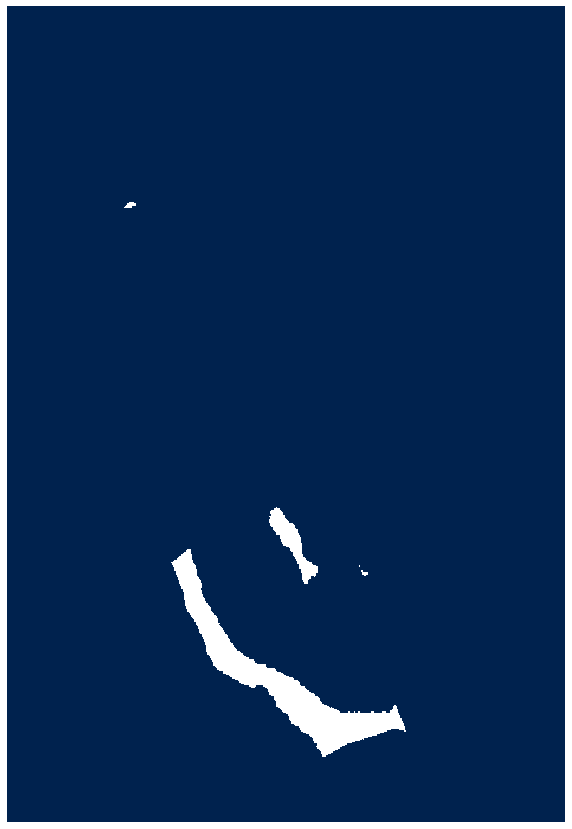

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1713: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1712: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/numpy/core/numeric.py:1632: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


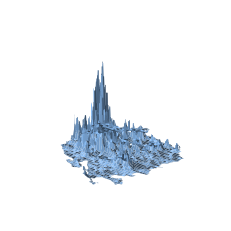

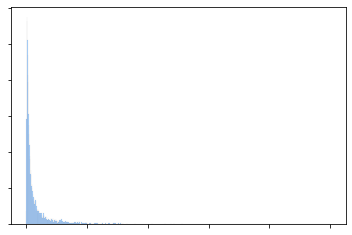



 Predictors: trains,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


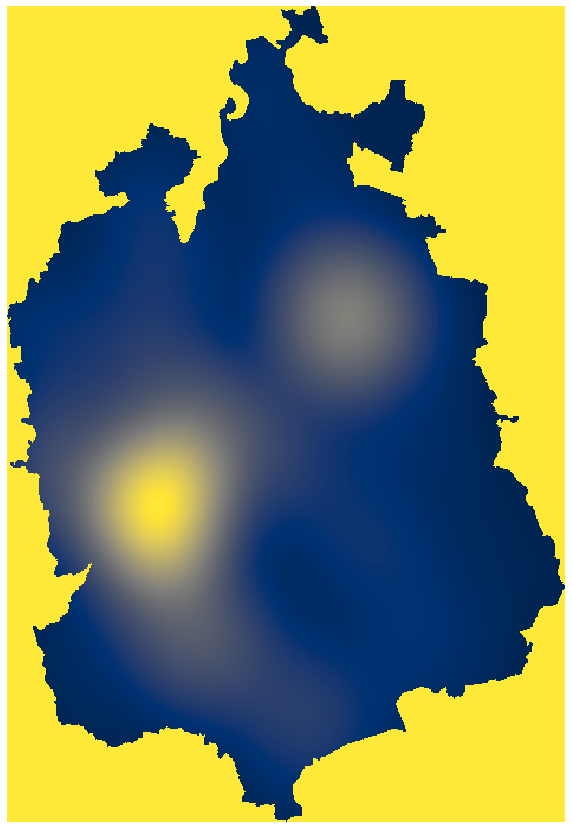

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


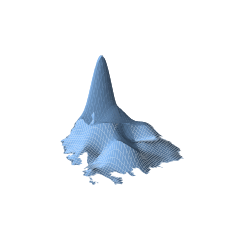

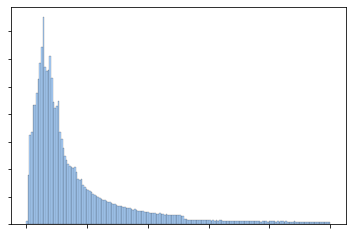



 Predictors: pop_municipalities,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


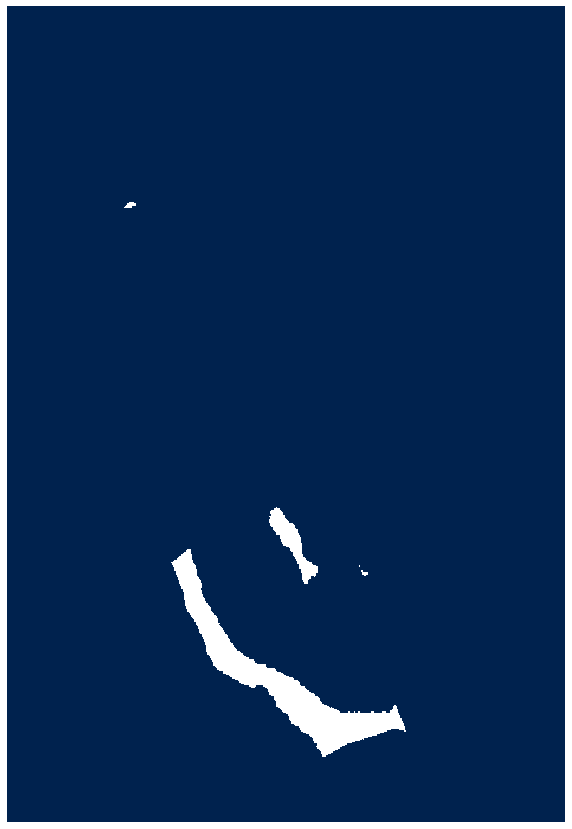

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1713: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1712: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/numpy/core/numeric.py:1632: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


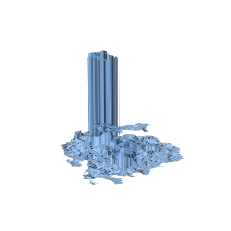

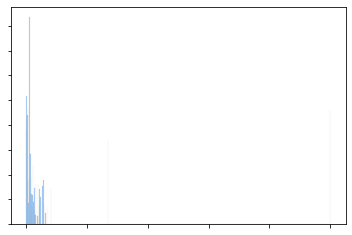



 Predictors: sups_coop,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


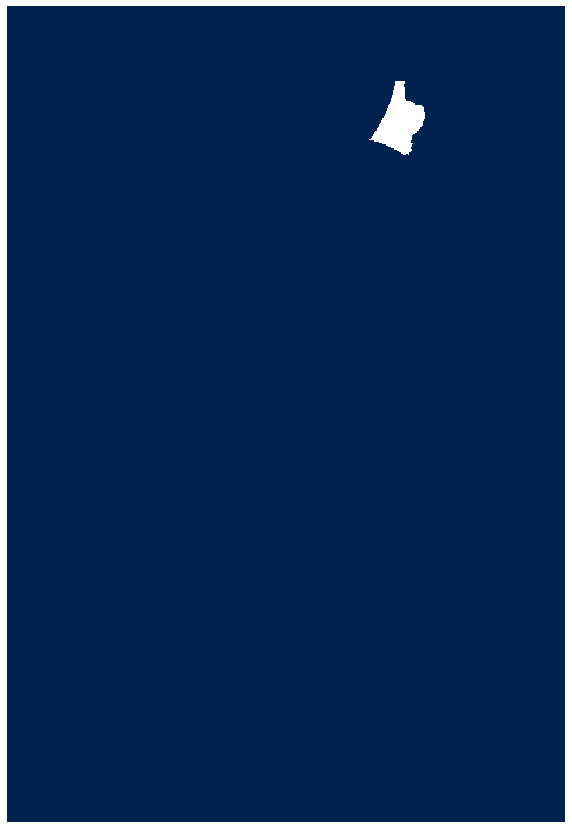

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1713: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1712: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/numpy/core/numeric.py:1632: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


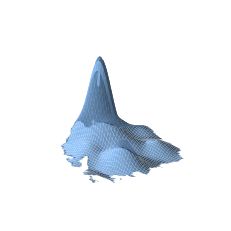

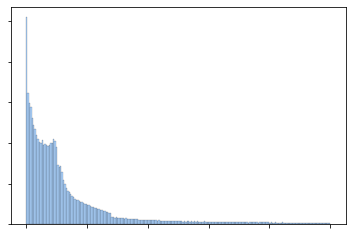



 Predictors: target,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


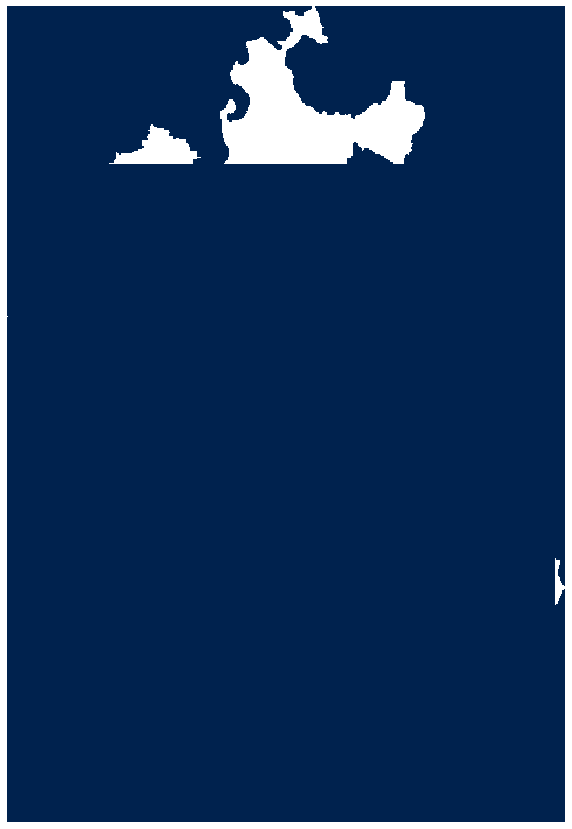

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1713: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1712: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


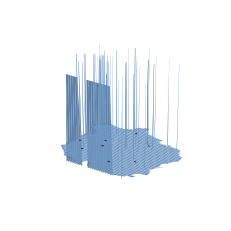

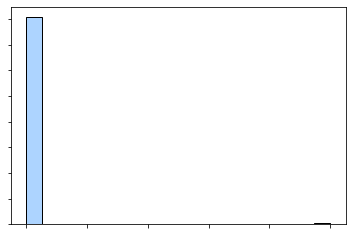



 Predictors: ref_100m,
 shape : (618, 472),
 max : --, 
 min : -- 


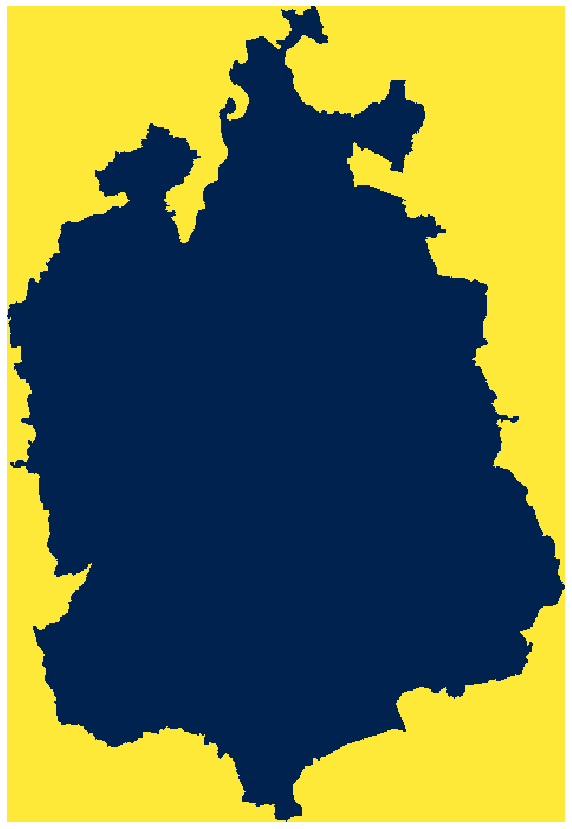

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


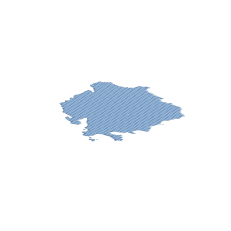

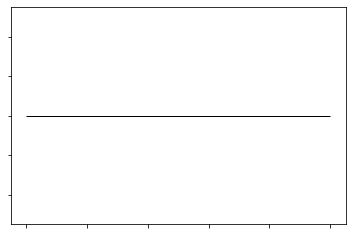



 Predictors: streets,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


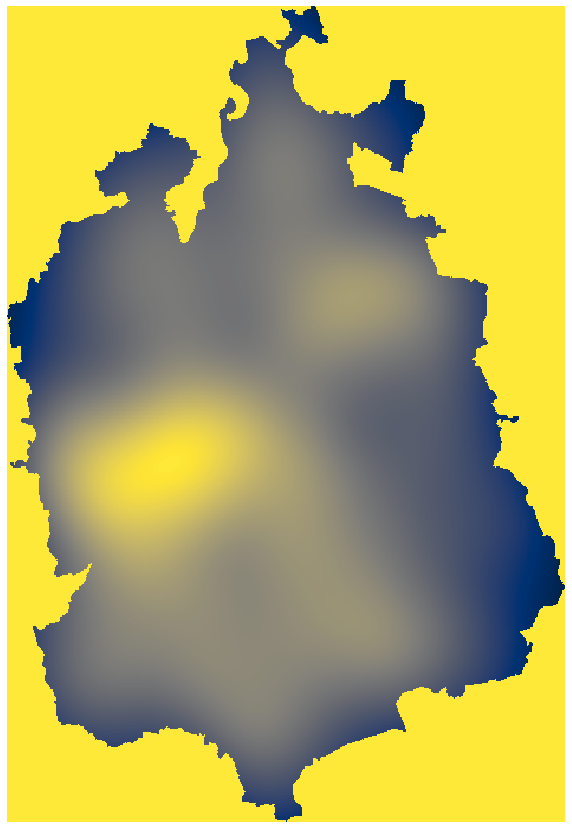

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


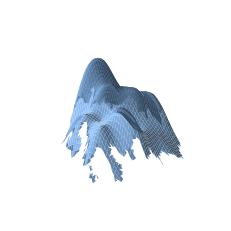

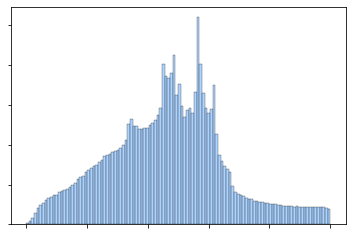



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


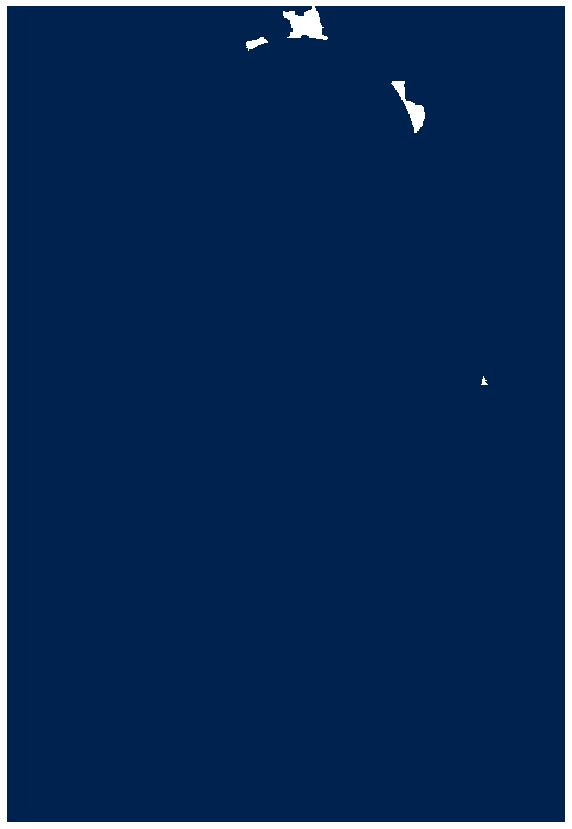

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1713: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1712: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/numpy/core/numeric.py:1632: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


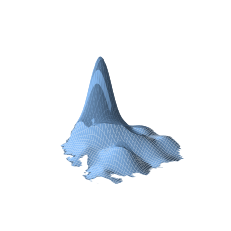

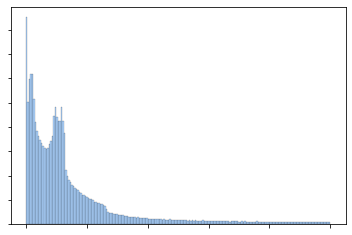

In [122]:
# Draw "flat" histogram and add it to pandas dataframe

for k,v in predictors.items():
    
    pred_arr = v
    # data and 2d array
    array = pred_arr
    min_val = np.ma.min(array[array>-9999])
    print(f"\n\n Predictors: {k},\n shape : {array.shape},\n max : {np.max(array)}, \n min : {min_val} ")
    fig = plt.figure( figsize=(10,15))
    hm = sns.heatmap(pred_arr, cmap = "cividis", cbar=False)
    hm.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])
    hm.tick_params(left = False, bottom = False)
    plt.axis()
    plt.pause(0.6)
    # 3d map
    make_3d_map(pred_arr, k, ref_array)
    plt.pause(0.6)
    flat_arr = pred_arr.flatten()
    
    hist = sns.histplot(flat_arr)
    hist.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])
    plt.pause(0.6)
  

In [123]:
# translate array to dataframe

df_raw=pd.DataFrame({"mask" : ref_array.flatten()})

for k,v in predictors.items():
    pred_arr = v
    flat_arr = pred_arr.flatten()
    df_raw[k]=flat_arr
    
# replace -inf with 0
df_raw = df_raw.replace([np.inf, -np.inf], 0)

# remove unwanted rows and columns
df2 = df_raw.copy()
df2 = df2.dropna()
df2 = df2.drop(columns = [ "night_image_2","ref_100m", "night_image", "pop_municipalities"])

In [124]:
# clean target entries
df2 = df2[df2['mask']==1]
df2['target'] = df2['target'].apply(lambda x: 0 if x != 100 else 100 )

# remove pixels outside zurich
df2.describe()

,mask,bus,sups_aldi,trains,sups_coop,target,streets,sups_denner
count,173507.0,173507.000000,173507.000000,173507.000000,173507.000000,173507.000000,173507.000000,173507.000000
mean,1.0,20.903576,17.671341,17.155806,13.963059,0.350418,46.704079,15.043607
std,0.0,18.608101,19.426462,18.310595,18.002974,5.909249,19.469902,18.333916
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,8.002617,4.018137,5.765021,3.150712,0.000000,33.721594,3.586592
50%,1.0,16.926538,11.975488,10.191677,8.175628,0.000000,47.323650,9.675678
75%,1.0,26.140392,23.476194,21.053482,16.158924,0.000000,58.271919,17.412888
max,1.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


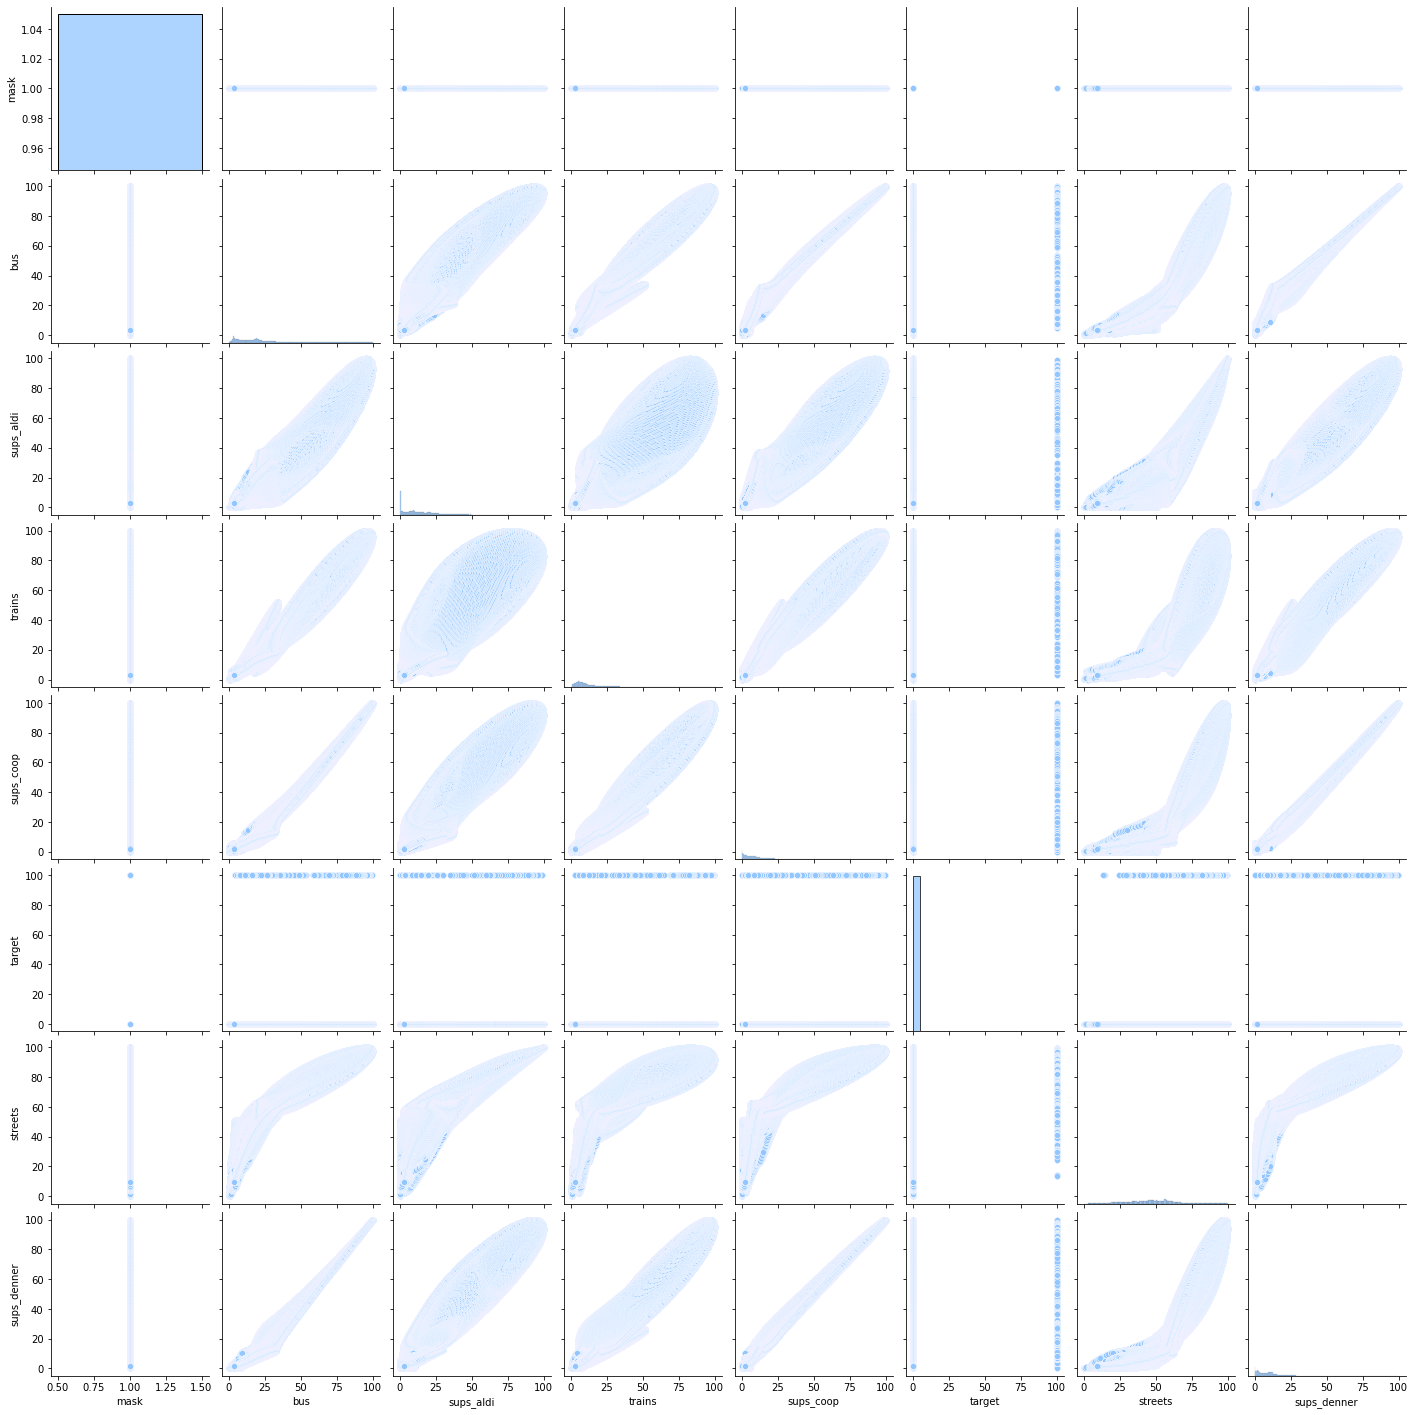

In [125]:
# Explore data cross-correlations
sns.pairplot(df2[1:])

## Feature engineering

The following steps were taken to provide the ML model with better, more useful data:

1. Improving population data
1. Reducing data leakage
1. Upsampling to create balance classes


### Improving resolution of population data

Differently from the other predictors, population data was available only at the scale of municipality (see map above). This is not compatible with our 100 x 100 m grid, and could generate artifacts and errors at the borders.  A simple interpolation of the population by municipality with the brightness value of night-images allows to improve the resolution of our population information.

array([  110,   130,   140, ..., 53440, 53870, 57970])

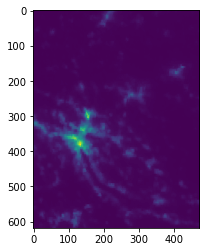

In [126]:
# import pop density without correction
ref_name = "pop_municipalities.tif"
file = gdal.Open(os.path.join(fold_path, ref_name))
pop_mun = file.GetRasterBand(1).ReadAsArray()

# import night image
ref_name = "night_image_2.tif"
file = gdal.Open(os.path.join(fold_path, ref_name))
night_im = file.GetRasterBand(1).ReadAsArray()
# clean night image
night_im[ night_im < 0 ] = 0
night_im = night_im.round().astype(int)

plt.imshow(night_im)
np.unique(night_im)

In [127]:
# normalise night image values using total population by municipality
fin_im = np.zeros(pop_mun.shape)

for pop in np.unique( pop_mun[pop_mun>0] ):
    # print(pop)
    # select only one municipality at a time
    mask = pop_mun != int(pop)
    ma_night_im = np.ma.masked_where(mask, night_im)
    
    # print("unique values of night_im : ",np.ma.unique(ma_night_im), ma_night_im.count()) 
   
    # get conversion factor and apply it to night image
    night_im_sum = np.ma.sum(ma_night_im)
    conv_factor  = pop / night_im_sum
    assert conv_factor > 0,f" problem with conv_factor: {conv_factor}"
    conv_ma_night_im = np.multiply(ma_night_im, conv_factor)
    fin_im = np.where( pop_mun != pop,  conv_ma_night_im , fin_im )
    
df2["pop_density"] = fin_im[ ref_array>0 ].flatten()
df2["pop_density"] = 100*df2["pop_density"]/np.max(df2["pop_density"])

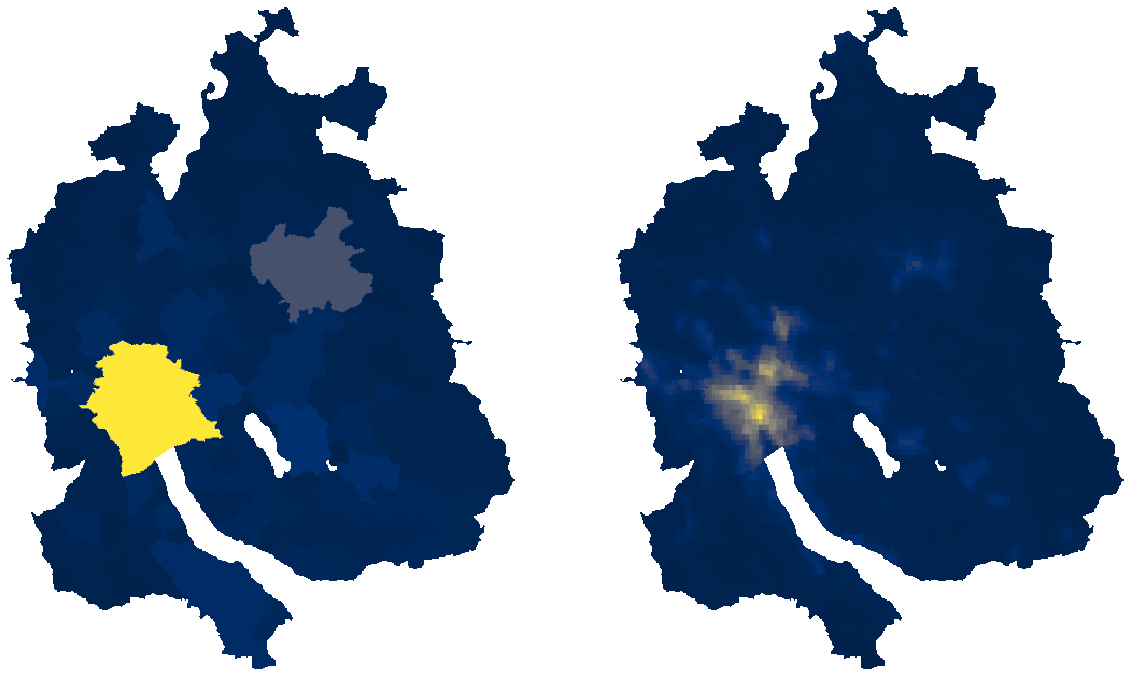

In [128]:
# Visualze results
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,25))

#TODO improve this viz
#old_arr = 100*(pop_mun-np.min(pop_mun) ) / ( np.max(pop_mun)-np.min(pop_mun))
#axs[0].imshow( old_arr )
#axs[1].imshow(fin_im)
# viz old and new pop density data
# prepare old array
from matplotlib.colors import TwoSlopeNorm
old = pop_mun
old = np.ma.masked_where(old<=0, old)

axs[0].imshow(old.reshape(pop_mun.shape), cmap="cividis", )
axs[0].set_axis_off()

new = fin_im
new = np.ma.masked_where(old<=0, new)
axs[1].imshow(new, cmap="cividis")
plt.grid(False)
axs[1].set_axis_off()

## Reducing data leakage. 
Many of the spatial predictors I used such as bus stations, roads, train stations are strictly correlated with the population density. Thus, normalizing by the population density provides more useful information to the model.

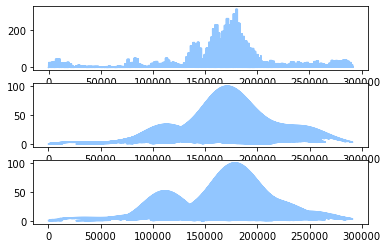

In [151]:
fig, axs = plt.subplots(ncols=1, nrows=3)
axs[0].plot(fin_im.flatten())
axs[1].plot(predictors["bus"].flatten())
axs[2].plot(predictors["trains"].flatten())

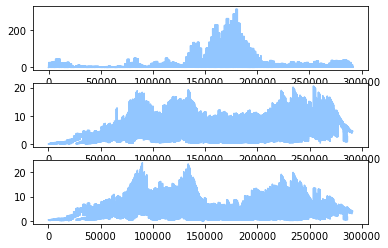

In [152]:
fig, axs = plt.subplots(ncols=1, nrows=3)
axs[0].plot(fin_im.flatten())
axs[1].plot(predictors["bus"].flatten()/fin_im.flatten())
axs[2].plot(predictors["trains"].flatten()/fin_im.flatten())


In [131]:
# Actually removing pop influence from other predictors
def norm_scale(arr, pop_arr = df2["pop_density"]) ->np.array:
    norm_arr = arr/pop_arr
    scaled_arr = 100*norm_arr/np.max(norm_arr)
    return scaled_arr

df3 = df2.copy()
df3["bus"]=norm_scale(df3["bus"])
df3["trains"]=norm_scale(df3["trains"])


## Predicting current locations
Since this a classification problem, logistic regression is the natural go-to model and with reasons. Before training the model we will use *upsampling* to balance classes 

In [165]:
# train test split with upsampling for minority class
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
df = df3[['bus', "sups_aldi", "trains", "sups_coop", "streets", "sups_denner", "pop_density", "target"]]

# upsampling 
df_majority = df[df.target!=100]
df_minority = df[df.target==100]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

print("upsampled values check:" , df_upsampled.target.value_counts())

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_upsampled.iloc[:, :7], 
                                                   df_upsampled.iloc[:,7], test_size=0.3)
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                   y_train, test_size=0.4)
# validation

print("train size", x_train.shape[0], x_train.shape[0]/df_upsampled.shape[0])
print("test size", x_test.shape[0], x_test.shape[0]/df_upsampled.shape[0])
print("val size", x_val.shape[0], x_val.shape[0]/df_upsampled.shape[0])

upsampled values check: 0      172899
100    172899
Name: target, dtype: int64
train size 145234 0.4199966454404016
test size 103740 0.30000173511703365
val size 96824 0.28000161944256474


# logistic regression

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 72 epochs took 4 seconds
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     48642
         100       0.82      0.92      0.87     48182

    accuracy                           0.86     96824
   macro avg       0.87      0.86      0.86     96824
weighted avg       0.87      0.86      0.86     96824



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


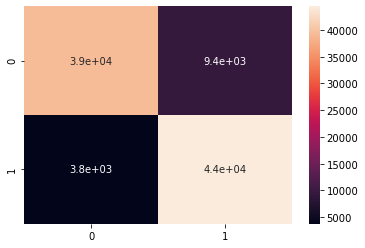

In [166]:
# TODO continue from here
from sklearn.linear_model import  LogisticRegression 
logReg = LogisticRegression(penalty='elasticnet', dual=False, tol=0.0001, C=1.0, 
                            fit_intercept=True, intercept_scaling=1, class_weight=None, 
                            random_state=123, solver='saga', max_iter=10000, multi_class='auto', 
                            verbose=1, warm_start=False, l1_ratio=0.3)

logReg.fit(x_train, y_train)

# test results
# predict and analyse results (LOGREG)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_pred = logReg.predict(x_val)

df_pred=pd.DataFrame( { "true" : y_val, "predicted": y_pred } )  
print(classification_report(y_val, y_pred))

conf_m = confusion_matrix(y_val, y_pred, sample_weight=None, normalize=None)
sns.heatmap(conf_m, annot=True)
plt.pause(0.6)

In [ ]:
# optimize parameters UNCOMMENT TO RUN
"""grid_values = {'penalty': ['l1','l2', 'elasticnet'], 
               'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100,1000], 
               'tol':[ 1e-05, 1e-04, 1e-03],
               'fit_intercept':[True, False],
               'l1_ratio': np.arange(0, 1, 0.2)
              }"""

# from sklearn.model_selection import GridSearchCV as gs
# optimised_model = gs(LogisticRegression(), grid_values,  scoring=None, n_jobs=-1, 
#                     refit=True, cv=None, 
#                     verbose=0, pre_dispatch='2*n_jobs', return_train_score=True)

# result=optimised_model.fit(x_train, y_train)

# get tuned parameters
# b_params = optimised_model.best_params_
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

In [167]:
# Train model with optimised params
"""Optimised parameters:
{'C': 0.001,
 'fit_intercept': True,
 'l1_ratio': 0.0,
 'penalty': 'l2',
 'tol': 1e-05})"""

b_params={'C': 0.001,
 'fit_intercept': True,
 'l1_ratio': 0.0,
 'penalty': 'l2',
 'tol': 1e-05}

opt_model= LogisticRegression()
opt_model.set_params(**b_params)
opt_model.fit(x_train,y_train)
# 

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


LogisticRegression(C=0.001, l1_ratio=0.0, tol=1e-05)

### 

## Exploring results

              precision    recall  f1-score   support

           0       0.91      0.81      0.86     48642
         100       0.82      0.92      0.87     48182

    accuracy                           0.86     96824
   macro avg       0.87      0.86      0.86     96824
weighted avg       0.87      0.86      0.86     96824



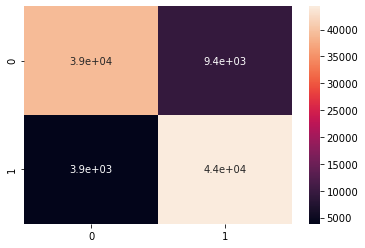

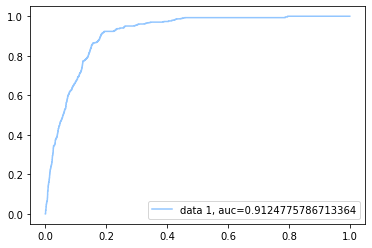

In [168]:
# (if logistic regression) ROC curve and outliers
# (if logistic regression) ROC curve and outliers

y_pred = opt_model.predict(x_val)

df_pred=pd.DataFrame( { "true" : y_val, "predicted": y_pred } )  
print(classification_report(y_val, y_pred))

conf_m = confusion_matrix(y_val, y_pred, sample_weight=None, normalize=None)
sns.heatmap(conf_m, annot=True)
plt.pause(0.6)

from sklearn import metrics
y_pred_proba = logReg.predict_proba(x_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test/100,  y_pred_proba)
auc = metrics.roc_auc_score(y_test/100, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

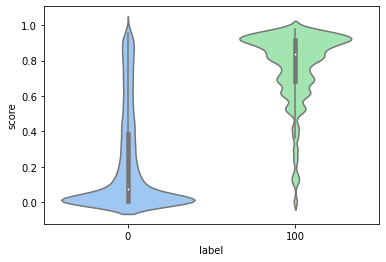

In [169]:
# visdualise probalities of migros and no-migros pixels
data=pd.DataFrame({"label": y_test,"score": y_pred_proba })
sns.violinplot(x="label", y="score", data=data)
None

feat name Index(['bus', 'sups_aldi', 'trains', 'sups_coop', 'streets', 'sups_denner',
       'pop_density'],
      dtype='object')


<BarContainer object of 7 artists>

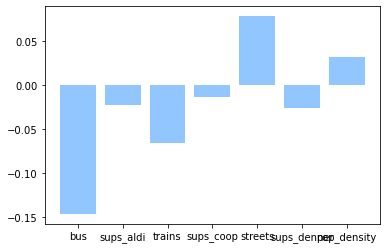

In [170]:
# Explore coefficients of regression

r_coef = opt_model.coef_
features_name=x_train.columns
print("feat name", features_name)
coef_dict = {}
for coef, feat in zip(r_coef[0,:],features_name):
    coef_dict[feat] = coef
    
plt.bar(coef_dict.keys(),height=coef_dict.values())



### Conclusion from coefficients

Ideal location for Migros is:

- near bus stations 
- near the train stations
- near the main roads
- far from Denners
- in high pop. density areas

### Finding new locations
Using the trained model, we can now calculate the favorability of the areas currently without a Migros

In [172]:
# get locations without predictions
df_no_migros=df.copy()
df_no_migros=df_no_migros[df_no_migros['target']!=100]
df_no_migros.head()
# get predictors data
x_no_migros = df_no_migros.iloc[:, :7]
# PREDICT
y_no_migros = opt_model.predict_proba(x_no_migros)[::,1]


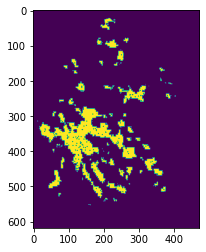

In [173]:
# transfer new prediction to raster using gdal and create map 
df_no_migros["pred_proba"] = y_no_migros
df_no_migros.head()

df_pred = pd.concat([df_raw, df_no_migros[["pred_proba"]]], axis=1)
pred_arr = df_pred["pred_proba"].to_numpy()

pred_arr = pred_arr.reshape(ref_array.shape)
plt.imshow(pred_arr>0.6)

predicted :  26379
reference :  173507


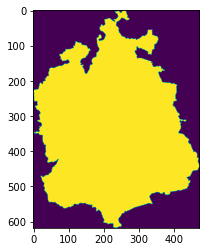

In [174]:
# missing transfer new prediction to raster using gdal and create map (might be needed to add a key column)
plt.imshow(ref_array)
print("predicted : ", np.sum(pred_arr > 0.6 ))
print("reference : ", np.sum(ref_array > 0.9 ))

## Exporting data and visualisation

In [ ]:
src_filename = os.path.join(fold_path, ref_name)
dst_filename = os.path.join(fold_path, "output_predictions")


In [ ]:
#1.    
tiff_file = gdal.Open(src_filename)
#2.
geotransform = tiff_file.GetGeoTransform()
projection = tiff_file.GetProjection()
band = tiff_file.GetRasterBand(1)    
xsize = band.XSize
ysize = band.YSize
#5.
driver = gdal.GetDriverByName('GTiff')
new_tiff = driver.Create(dst_filename,xsize,ysize,1,gdal.GDT_Int16)
new_tiff.SetGeoTransform(geotransform)
new_tiff.SetProjection(projection)
new_tiff.GetRasterBand(1).WriteArray(100*pred_arr)
new_tiff.FlushCache() #Saves to disk 
new_tiff = None #closes the file